In [1]:
from CherryTreeDataset import CherryTreeDataset
from torchvision import transforms
from funciones_auxiliares import plot_spectra, analyze_image, analyze_tiff_metadata, PATH, crop_central_region
from resnet_adapters import adapt_resnet_channels
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, SqueezeNet1_1_Weights
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn


In [2]:
# Define las transformaciones si son necesarias
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Lambda(lambda x: crop_central_region(x, center_ratio=0.8)),
    transforms.ToTensor()
])

formats = ( 'RGB.JPG','RED.TIF','GRE.TIF','NIR.TIF','REG.TIF')
#formats = ('RGB.JPG','NIR.TIF','REG.TIF')
#formats = ('RGB.JPG',)
dataset = CherryTreeDataset(PATH, transform=transform, formats = formats, concatenate = True, healthy_ratio=4)

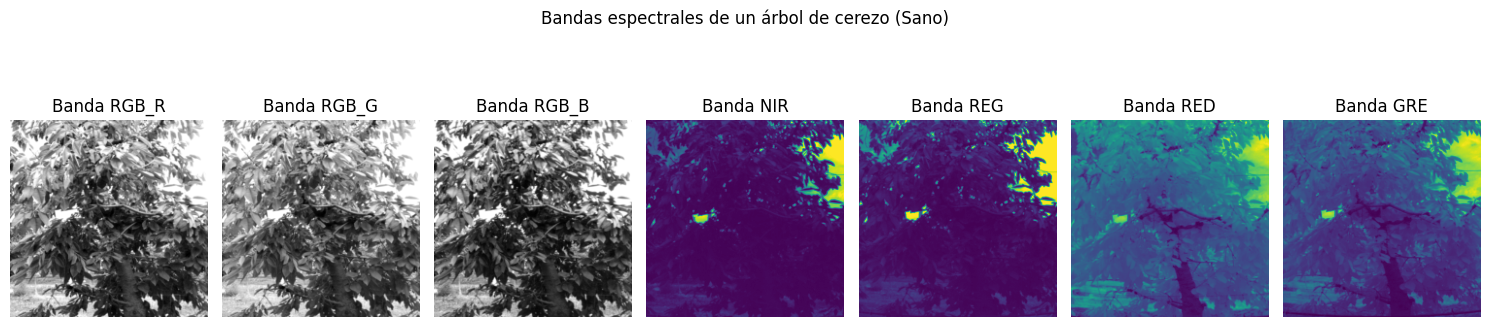

Number of samples for Healthy: 824
Number of samples for Disease: 206


In [3]:
images, label = dataset[20]  
plot_spectra(images, label)
dataset.print_class_counts()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'El dispositivo seleccionado es {device}')

El dispositivo seleccionado es cuda


In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader para manejar los lotes de datos
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=20)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=20)

#resnet = models.squeezenet1_1(SqueezeNet1_1_Weights.IMAGENET1K_V1)
#resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# Adapta el modelo para aceptar 4 canales
resnet = adapt_resnet_channels(resnet, 7)

print(resnet)


num_classes = 2  # Número de clases en tu dataset
resnet.fc = nn.Sequential(
    nn.Dropout(0.5),  # Añade dropout con una probabilidad de 0.5
    nn.Linear(resnet.fc.in_features, 128),  # Primera reducción a 64
    nn.ReLU(),
    nn.Dropout(0.5),  # Añade dropout con una probabilidad de 0.5
    nn.Linear(128, 32),  # Primera reducción a 64
    nn.ReLU(),
    nn.Dropout(0.5),  # Añade dropout con una probabilidad de 0.5
    nn.Linear(32, 1),
)
resnet.to(device)

for param in resnet.parameters():
    param.requires_grad = False


# Descongelar todas las capas en `layer4`
for param in resnet.layer4.parameters():
    param.requires_grad = True
#for param in resnet.layer3.parameters():
#    param.requires_grad = True
#for param in resnet.conv1.parameters():
#    param.requires_grad = True

# Descongelar la capa `avgpool` y `fc`
for param in resnet.avgpool.parameters():
    param.requires_grad = True

for param in resnet.fc.parameters():
    param.requires_grad = True

#print(resnet)
#for name, param in resnet.named_parameters():
#    print(f"{name}: requires_grad={param.requires_grad}")



ResNet(
  (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

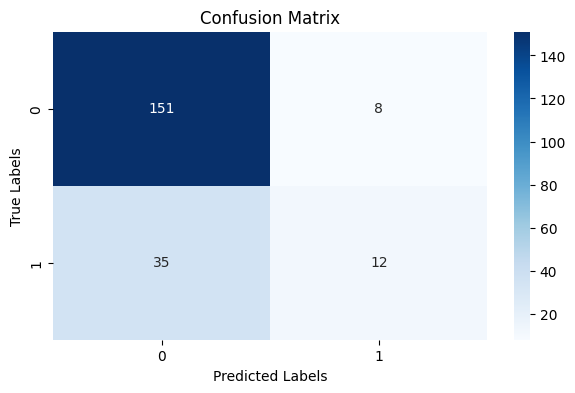

Epoch [1/15], Train Loss: 0.0626, Validation Loss: 0.6682, Accuracy: 79.13%


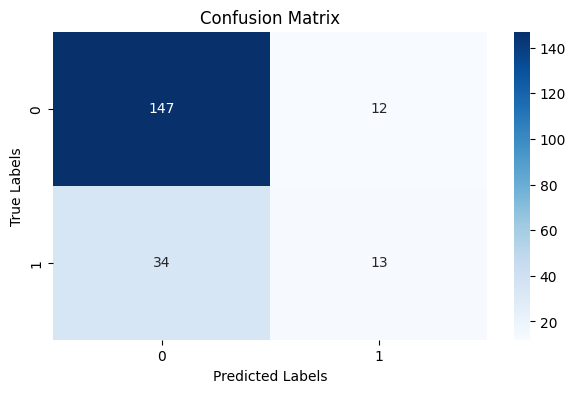

Epoch [2/15], Train Loss: 0.0455, Validation Loss: 0.7068, Accuracy: 77.67%


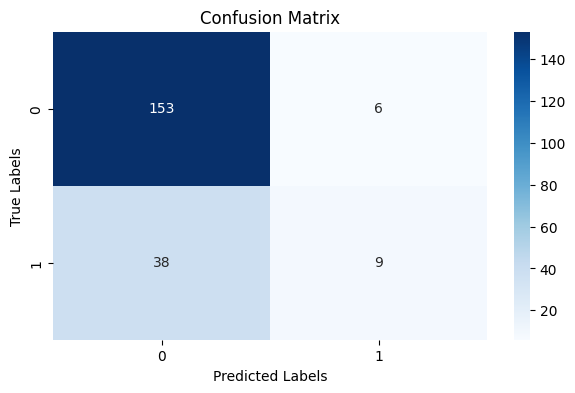

Epoch [3/15], Train Loss: 0.0377, Validation Loss: 0.8898, Accuracy: 78.64%


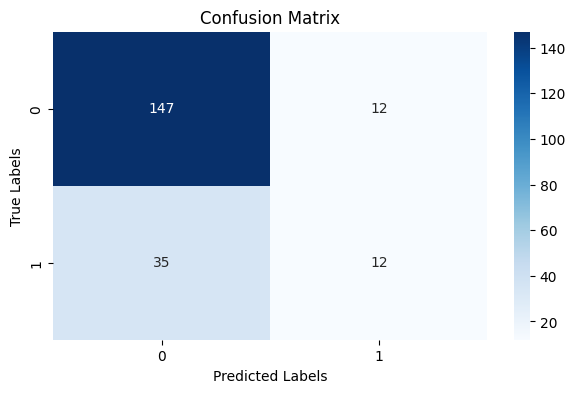

Epoch [4/15], Train Loss: 0.0349, Validation Loss: 0.7352, Accuracy: 77.18%


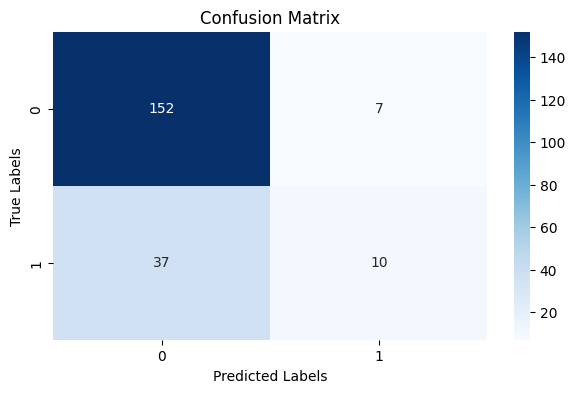

Epoch [5/15], Train Loss: 0.0273, Validation Loss: 0.8668, Accuracy: 78.64%


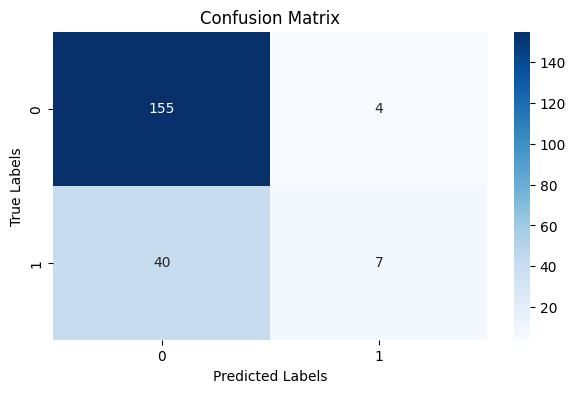

Epoch [6/15], Train Loss: 0.0279, Validation Loss: 1.1465, Accuracy: 78.64%


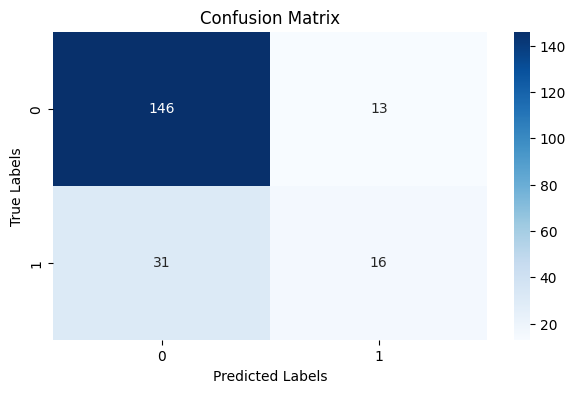

Epoch [7/15], Train Loss: 0.0310, Validation Loss: 1.1067, Accuracy: 78.64%


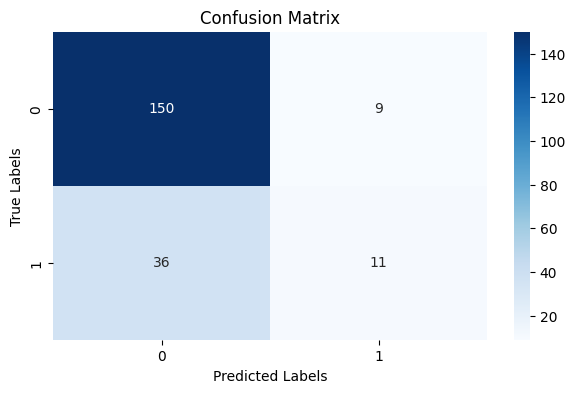

Epoch [8/15], Train Loss: 0.0296, Validation Loss: 1.0458, Accuracy: 78.16%


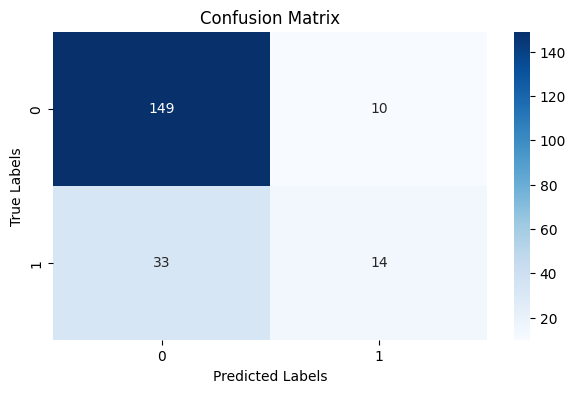

Epoch [9/15], Train Loss: 0.0204, Validation Loss: 0.9715, Accuracy: 79.13%


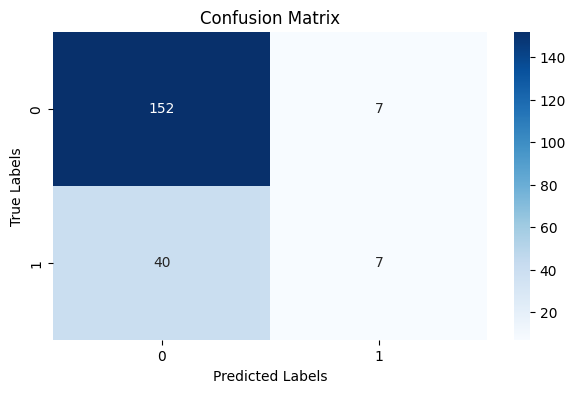

Epoch [10/15], Train Loss: 0.0246, Validation Loss: 1.0937, Accuracy: 77.18%


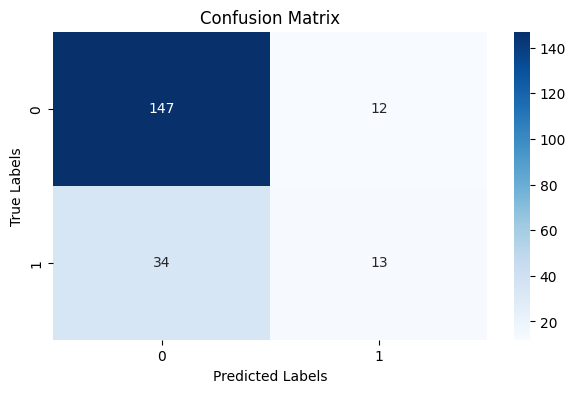

Epoch [11/15], Train Loss: 0.0229, Validation Loss: 1.0839, Accuracy: 77.67%


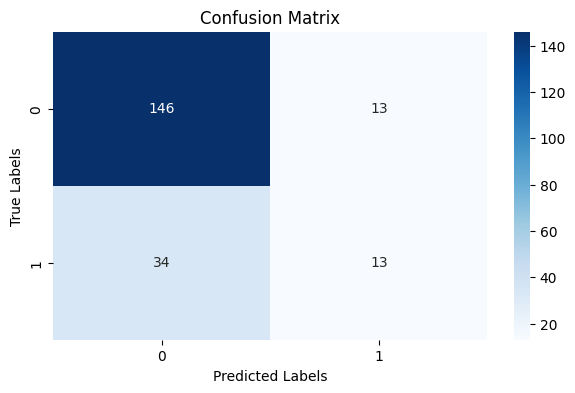

Epoch [12/15], Train Loss: 0.0145, Validation Loss: 1.1026, Accuracy: 77.18%


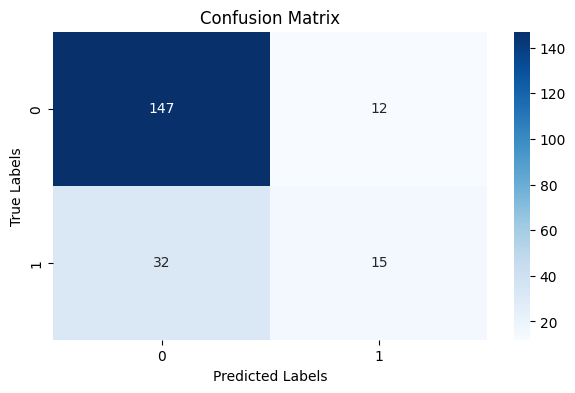

Epoch [13/15], Train Loss: 0.0207, Validation Loss: 1.1909, Accuracy: 78.64%


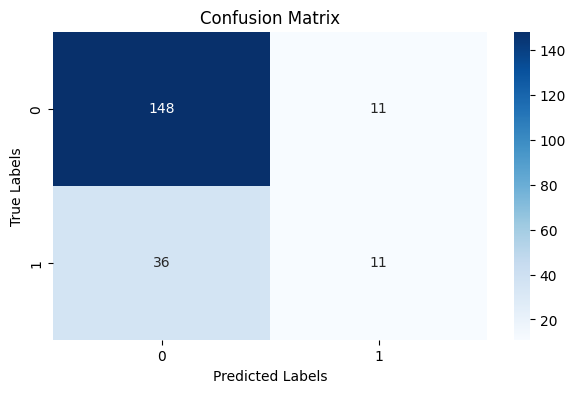

Epoch [14/15], Train Loss: 0.0236, Validation Loss: 1.1376, Accuracy: 77.18%


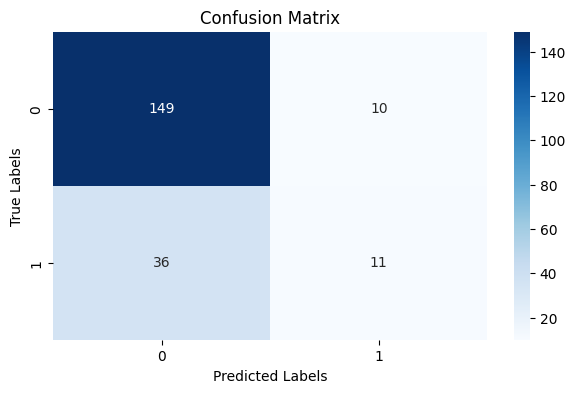

Epoch [15/15], Train Loss: 0.0202, Validation Loss: 1.3647, Accuracy: 77.67%


In [7]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.00002, weight_decay=1e-3)
num_epochs = 15
for epoch in range(num_epochs):
    resnet.train()
    train_loss = 0
    for images, labels in train_loader:
        #print('iter')
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculando la pérdida promedio en la época
    train_loss /= len(train_loader)

    # Evaluación con el conjunto de validación/test
    resnet.eval()
    validation_loss = 0
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            labels = labels.float().view(-1, 1)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            predicted = torch.sigmoid(outputs).ge(0.5).float()  # ge es 'greater or equal'
            total += labels.size(0)
            correct += (predicted == labels).float().sum().item()  # Asegura que la suma se haga sobre floats
            all_predicted.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    validation_loss /= len(test_loader)
    accuracy = 100 * correct / total

    all_predicted = np.concatenate(all_predicted)
    all_labels = np.concatenate(all_labels)
    
    # Calculando la matriz de confusión
    conf_matrix = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(7,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [ ]:
print((predicted == labels))